<a href="https://colab.research.google.com/github/erikathea/PagPassGPT/blob/main/eval_pw_var.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Evaluating PagPassGPT Password Variant Generation using Composite Similarity Metric

The composite similarity score $S$ is calculated as follows:

> $S$ = ( $w_1$ x *Normalized\_Edit\_Distance* ) +
      ( $w_2$ x *Log\_Likelihood\_Similarity* ) +
      ( $w_3$ x *zxcvbn\_Similarity* )

where:

* Normalized\_Edit\_Distance = $1 - \frac{\text{Edit Distance}}{\text{Max Possible Edit Distance}}$, resulting in a similarity score where higher values indicate greater similarity.


* Log_Likelihood_Similarity = $ \exp\left(-|\text{Log Likelihood Difference}|\right)$, where smaller differences yield values closer to 1, indicating high similarity.

* zxcvbn_Similarity = $ 1 - \frac{|\text{zxcvbn Score Difference}|}{\text{Max zxcvbn Score = 4}} $
    
* $w_1$, $w_2$, and $w_3$ are weights that adjust the importance of structural versus perceptual similarity. These weights can be tuned based on the specific application and security requirements.


```
# Corrected weights for the composite similarity score
w1, w2, w3 = 0.25, 0.4, 0.35
```

# Init Eval Code
Execute these cells first to run desired test case/s

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
def compute():
  # Corrected weights for the composite similarity score
  w1, w2, w3 = 0.25, 0.4, 0.35

  # Compute the new columns for the filtered data
  df_filtered.loc[:, 'normalized_editDistance'] = 1 - (df_filtered['edit_distance'] / 32)
  abs_diff = np.abs(df_filtered['pw_zxcvbn_score'] - df_filtered['orig_zxcvbn_score'])
  max_diff = 4  # Maximum possible difference for zxcvbn scores
  df_filtered.loc[:, 'normalized_zxcvbnScore'] = 1 - (abs_diff / max_diff)
  df_filtered.loc[:, 'normalized_logLikelihood'] = np.exp(-(np.abs(df_filtered['pw_log_likelihood'] - df_filtered['orig_log_likelihood'])))

  # Print intermediate values for debugging
  print("Debugging Values:")
  print("Normalized Edit Distance:", df_filtered['normalized_editDistance'].describe())
  print("Normalized zxcvbn Score:", df_filtered['normalized_zxcvbnScore'].describe())
  print("Normalized Log Likelihood:", df_filtered['normalized_logLikelihood'].describe())

  # Calculate composite similarity score and add it to the DataFrame
  df_filtered.loc[:, 'composite_similarity_score'] = (
      (w1 * df_filtered['normalized_editDistance']) +
      (w2 * df_filtered['normalized_logLikelihood']) +
      (w3 * df_filtered['normalized_zxcvbnScore'])
  )

  # Check for any scores greater than 1.0 and print relevant rows
  if (df_filtered['composite_similarity_score'] > 1.0).any():
      print("Warning: Composite similarity score exceeded 1.0")
      print(df_filtered.loc[df_filtered['composite_similarity_score'] > 1.0, ['pw_variant', 'normalized_editDistance', 'normalized_zxcvbnScore', 'normalized_logLikelihood', 'composite_similarity_score']])

  print("composite_similarity_score:", df_filtered['composite_similarity_score'].describe())

  # Print the number of unique "orig_pw"
  unique_orig_pw_count = df_filtered['orig_pw'].nunique()
  print(f"Number of unique 'orig_pw': {unique_orig_pw_count}")
  print(f"Number of unique 'pw_variant': {df_filtered['pw_variant'].nunique()}")



In [ ]:
# Create the scatter plot
def create_scatter_plot(title):
  plt.figure(figsize=(18,10))

  plt.scatter(df_filtered.index, df_filtered['normalized_editDistance'], label='norm_editDistance', color='blue', s=10, alpha=0.5)
  plt.scatter(df_filtered.index, df_filtered['normalized_zxcvbnScore'], label='norm_zxcvbnScore', color='red', s=10, alpha=0.5)
  plt.scatter(df_filtered.index, df_filtered['normalized_logLikelihood'], label='norm_LogLikelihood', color='orange', s=10, alpha=0.5)
  plt.scatter(df_filtered.index, df_filtered['composite_similarity_score'], label='composite_similarity_score', color='green', s=20, alpha=1)

  plt.ylim(0, 1.1)  # Set y-axis limits
  plt.xlabel('Index')
  plt.ylabel('Score')
  plt.title(title)
  plt.legend()

  plt.grid(True, axis='y', linestyle='--', alpha=0.7)

  plt.tight_layout()
  plt.show()

# Test Cases

## L4N1 orig_pw: beta1

In [ ]:
# Read the file
with open('test-beta.csv', 'r') as file:
    lines = file.readlines()
# Process the lines
data = []
for line in lines[1:]:  # Skip the header line
    parts = line.strip().split(' - ', 1)
    if len(parts) == 2:
        _, fields = parts
        data.append(fields.split('\t'))

print(f"Data: {len(data)}")

# Create DataFrame
columns = ['datetime','orig_pw', 'orig_pattern', 'orig_zxcvbn_score', 'orig_zxcvbn_guesses',
           'orig_log_likelihood', 'pw_variant', 'pattern', 'pw_zxcvbn_score',
           'pw_zxcvbn_guesses', 'pw_log_likelihood', 'edit_distance', 'similarity_ratio']
df = pd.DataFrame(data, columns=columns)

# Convert necessary columns to numeric
numeric_columns = ['orig_zxcvbn_score', 'orig_zxcvbn_guesses', 'orig_log_likelihood',
                   'pw_zxcvbn_score', 'pw_zxcvbn_guesses', 'pw_log_likelihood',
                   'edit_distance', 'similarity_ratio']
for col in numeric_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Filter rows where edit_distance
df_filtered = df.copy()

Data: 972


In [ ]:
compute()

Debugging Values:
Normalized Edit Distance: count    972.000000
mean       0.785687
std        0.053711
min        0.687500
25%        0.750000
50%        0.781250
75%        0.812500
max        0.875000
Name: normalized_editDistance, dtype: float64
Normalized zxcvbn Score: count    972.000000
mean       0.576132
std        0.117874
min        0.250000
25%        0.500000
50%        0.500000
75%        0.750000
max        0.750000
Name: normalized_zxcvbnScore, dtype: float64
Normalized Log Likelihood: count    972.000000
mean       0.622703
std        0.164319
min        0.253919
25%        0.499369
50%        0.600287
75%        0.735694
max        0.997595
Name: normalized_logLikelihood, dtype: float64
composite_similarity_score: count    972.000000
mean       0.647149
std        0.093929
min        0.436178
25%        0.573053
50%        0.630203
75%        0.716272
max        0.880199
Name: composite_similarity_score, dtype: float64
Number of unique 'orig_pw': 1
Number of unique 'p

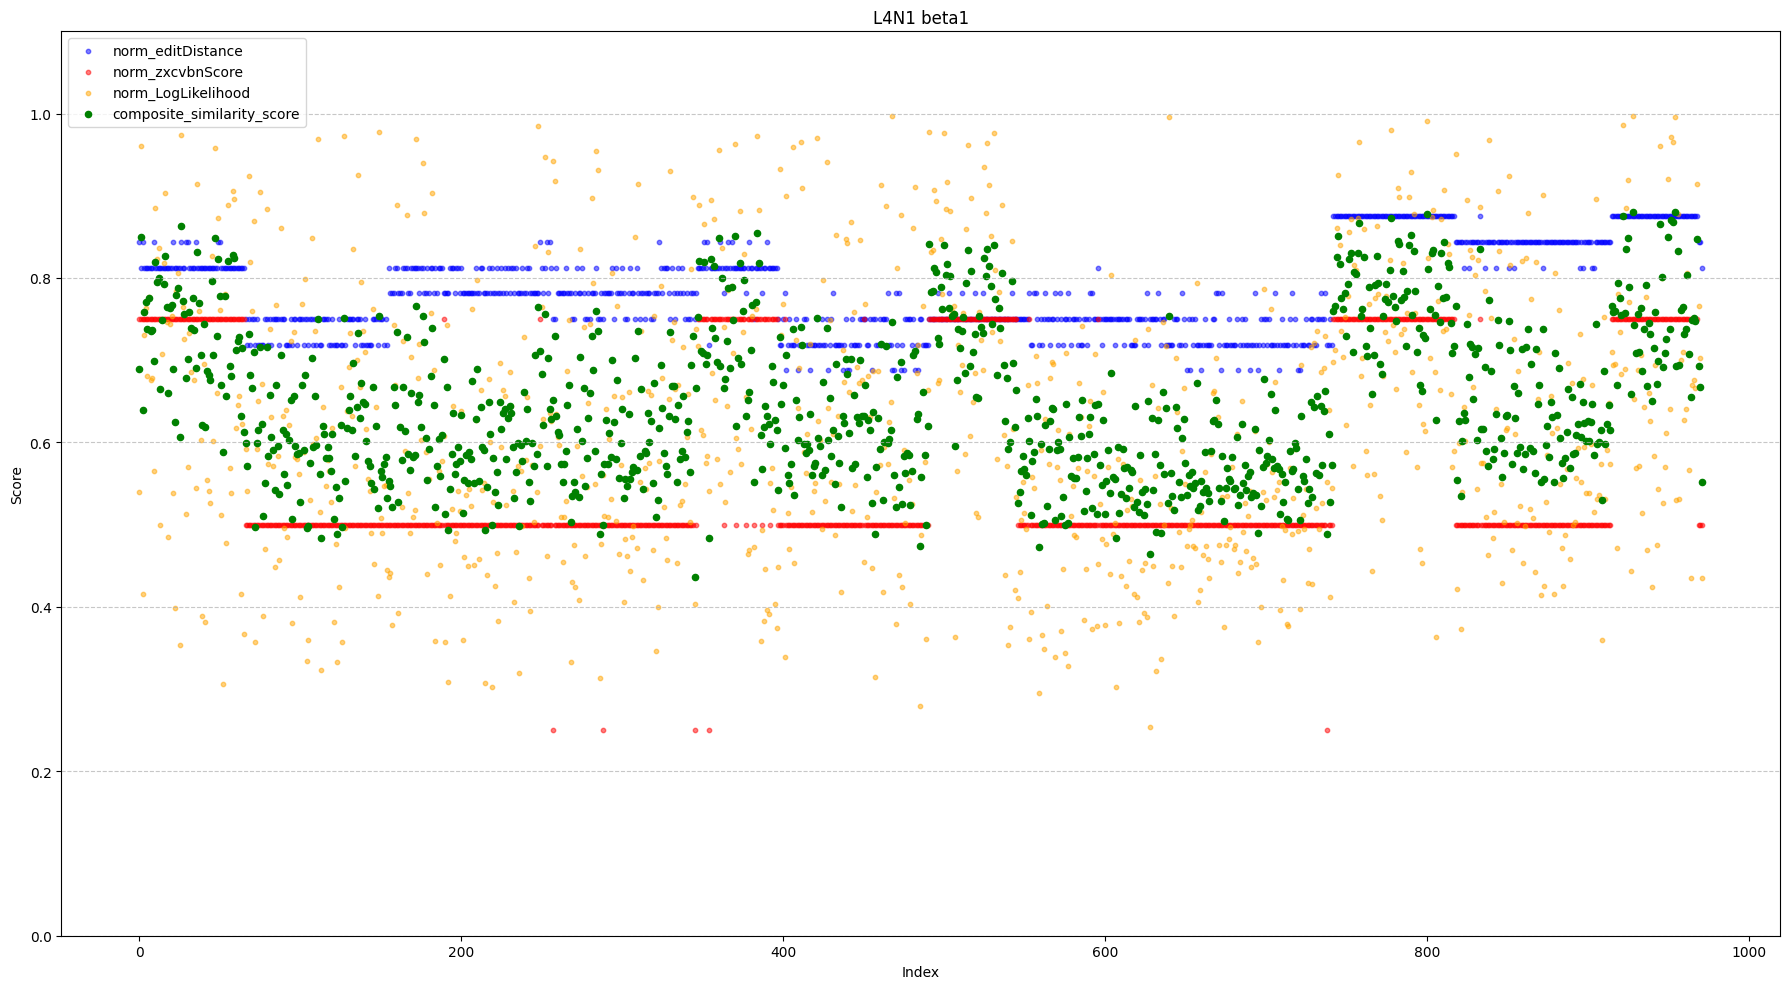

In [ ]:
create_scatter_plot('L4N1 beta1')

**Composite Similarity Score:**
Given that the composite similarity score is designed to incorporate normalized edit distance, zxcvbn score, and log likelihood, the fact that the mean is **0.6471** and the maximum is **0.8802** suggests that, on average, the **password variants generated are fairly similar to the original password**.
The higher end of the score range indicates that there are variants that are quite similar to the original, while the lower end shows that some are less so.

***Graph Interpretation**
The scatter plot shows that the composite similarity score (green) is distributed throughout the middle to upper range, aligning with the other similarity metrics. This distribution supports the conclusion that most variants have a moderate to high similarity to the original password.

## L4N1S3

In [ ]:
# Read the file
with open('test-L4N1S3.csv', 'r') as file:
    lines = file.readlines()
# Process the lines
data = []
for line in lines[1:]:  # Skip the header line
    parts = line.strip().split(' - ', 1)
    if len(parts) == 2:
        _, fields = parts
        data.append(fields.split('\t'))
print(f"Data: {len(data)}")
# Create DataFrame
columns = ['datetime','orig_pw', 'orig_pattern', 'orig_zxcvbn_score', 'orig_zxcvbn_guesses',
           'orig_log_likelihood', 'pw_variant', 'pattern', 'pw_zxcvbn_score',
           'pw_zxcvbn_guesses', 'pw_log_likelihood', 'edit_distance', 'similarity_ratio']
df = pd.DataFrame(data, columns=columns)

# Convert necessary columns to numeric
numeric_columns = ['orig_zxcvbn_score', 'orig_zxcvbn_guesses', 'orig_log_likelihood',
                   'pw_zxcvbn_score', 'pw_zxcvbn_guesses', 'pw_log_likelihood',
                   'edit_distance', 'similarity_ratio']
for col in numeric_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Filter rows where edit_distance
df_filtered = df.copy()

Data: 1273853


In [ ]:
compute()

Debugging Values:
Normalized Edit Distance: count    1.273853e+06
mean     8.670894e-01
std      2.938740e-02
min      7.500000e-01
25%      8.437500e-01
50%      8.750000e-01
75%      8.750000e-01
max      1.000000e+00
Name: normalized_editDistance, dtype: float64
Normalized zxcvbn Score: count    1.273853e+06
mean     6.864776e-01
std      1.275666e-01
min      2.500000e-01
25%      5.000000e-01
50%      7.500000e-01
75%      7.500000e-01
max      1.000000e+00
Name: normalized_zxcvbnScore, dtype: float64
Normalized Log Likelihood: count    1.273853e+06
mean     5.535993e-01
std      1.741325e-01
min      1.545030e-01
25%      4.293981e-01
50%      5.187610e-01
75%      6.550784e-01
max      1.000000e+00
Name: normalized_logLikelihood, dtype: float64
composite_similarity_score: count    1.273853e+06
mean     6.784792e-01
std      8.608910e-02
min      3.705832e-01
25%      6.203204e-01
50%      6.733796e-01
75%      7.334768e-01
max      1.000000e+00
Name: composite_similarity_score, 

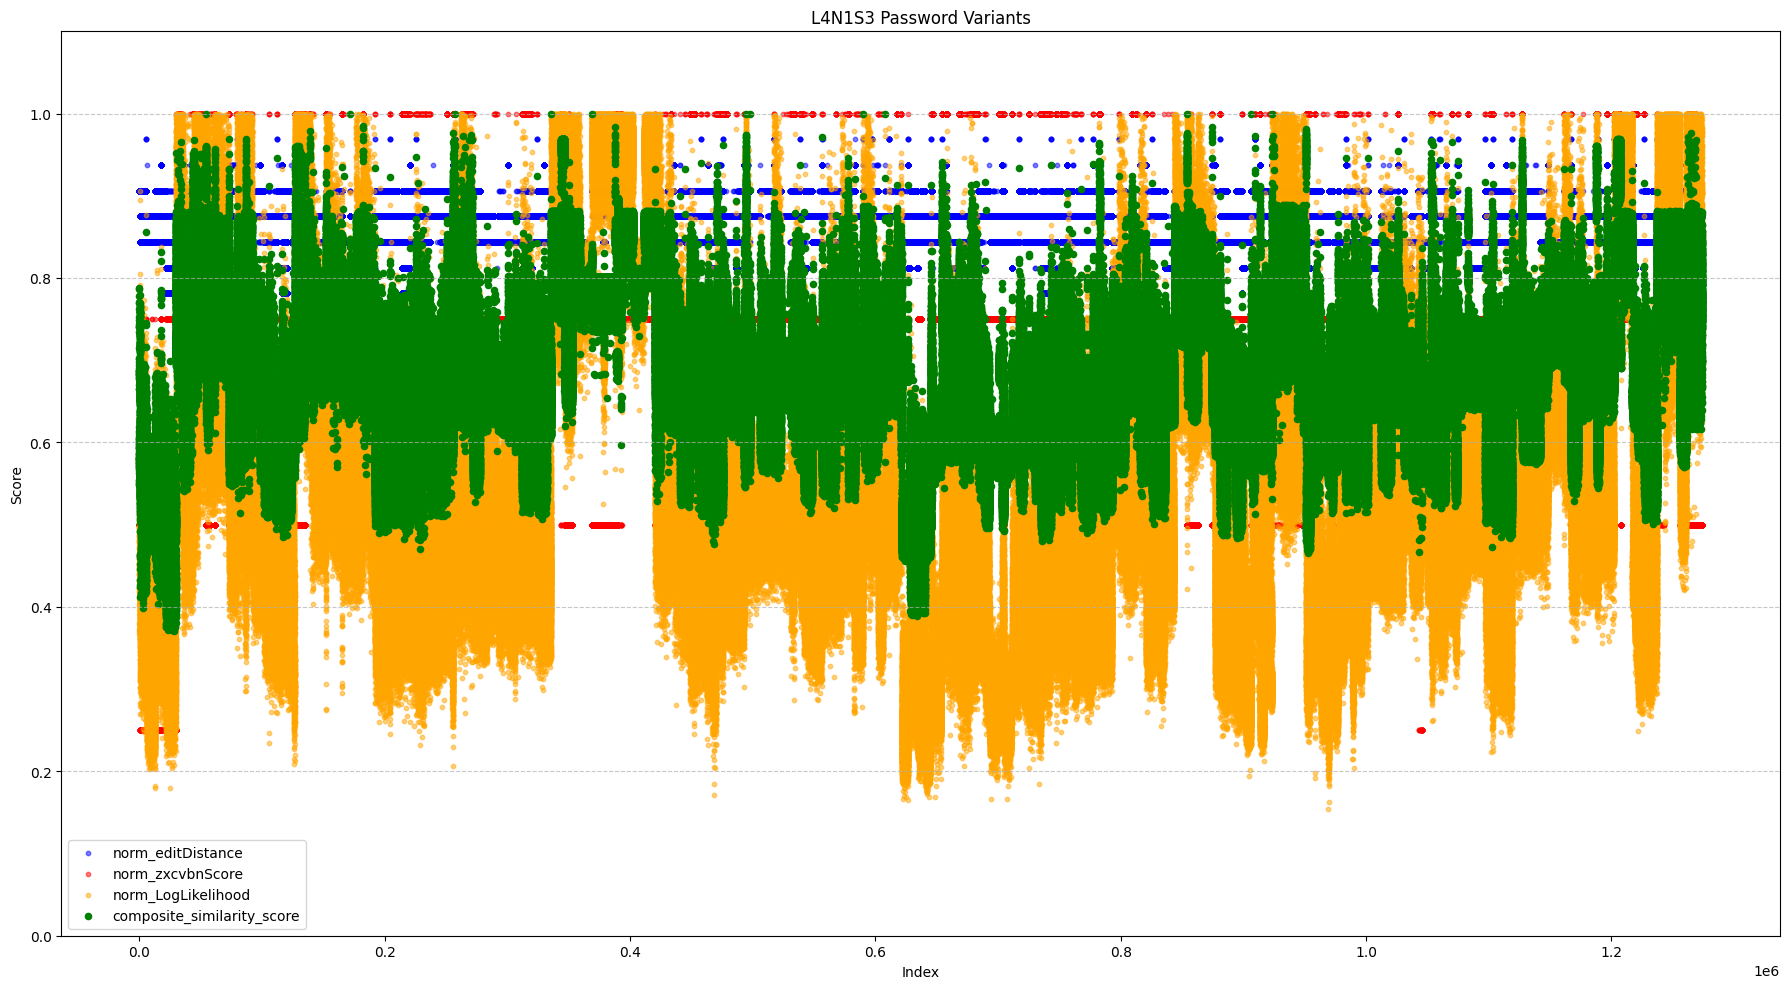

In [ ]:
create_scatter_plot('L4N1S3 Password Variants')

**Interpretation:**
The composite similarity score remains fairly high, with a mean close to 0.68. This suggests that overall, the variants are similar to the original passwords when considering all three factors (edit distance, zxcvbn score, log likelihood). The range of scores also indicates that while some variants are less similar, the majority are quite close.

## L4N2S2

In [9]:
# Read the file
with open('test-L4N2S2.csv', 'r') as file:
    lines = file.readlines()
# Process the lines
data = []
for line in lines[1:]:  # Skip the header line
    parts = line.strip().split(' - ', 1)
    if len(parts) == 2:
        _, fields = parts
        data.append(fields.split('\t'))
print(f"Data: {len(data)}")
# Create DataFrame
columns = ['datetime','orig_pw', 'orig_pattern', 'orig_zxcvbn_score', 'orig_zxcvbn_guesses',
           'orig_log_likelihood', 'pw_variant', 'pattern', 'pw_zxcvbn_score',
           'pw_zxcvbn_guesses', 'pw_log_likelihood', 'edit_distance', 'similarity_ratio']
df = pd.DataFrame(data, columns=columns)

# Convert necessary columns to numeric
numeric_columns = ['orig_zxcvbn_score', 'orig_zxcvbn_guesses', 'orig_log_likelihood',
                   'pw_zxcvbn_score', 'pw_zxcvbn_guesses', 'pw_log_likelihood',
                   'edit_distance', 'similarity_ratio']
for col in numeric_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Filter rows where edit_distance
df_filtered = df.copy()

Data: 14425877


In [10]:
compute()

Debugging Values:
Normalized Edit Distance: count    1.442588e+07
mean     8.514408e-01
std      3.507109e-02
min      6.562500e-01
25%      8.437500e-01
50%      8.437500e-01
75%      8.750000e-01
max      1.000000e+00
Name: normalized_editDistance, dtype: float64
Normalized zxcvbn Score: count    1.442588e+07
mean     6.913728e-01
std      1.184288e-01
min      2.500000e-01
25%      5.000000e-01
50%      7.500000e-01
75%      7.500000e-01
max      1.000000e+00
Name: normalized_zxcvbnScore, dtype: float64
Normalized Log Likelihood: count    1.442588e+07
mean     5.106436e-01
std      1.612389e-01
min      9.545847e-02
25%      3.908466e-01
50%      4.856650e-01
75%      6.085545e-01
max      1.000000e+00
Name: normalized_logLikelihood, dtype: float64
composite_similarity_score: count    1.442588e+07
mean     6.590981e-01
std      7.475666e-02
min      3.174824e-01
25%      6.085946e-01
50%      6.524711e-01
75%      7.048073e-01
max      1.000000e+00
Name: composite_similarity_score, 

<ipython-input-4-62e0debbb878>:18: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


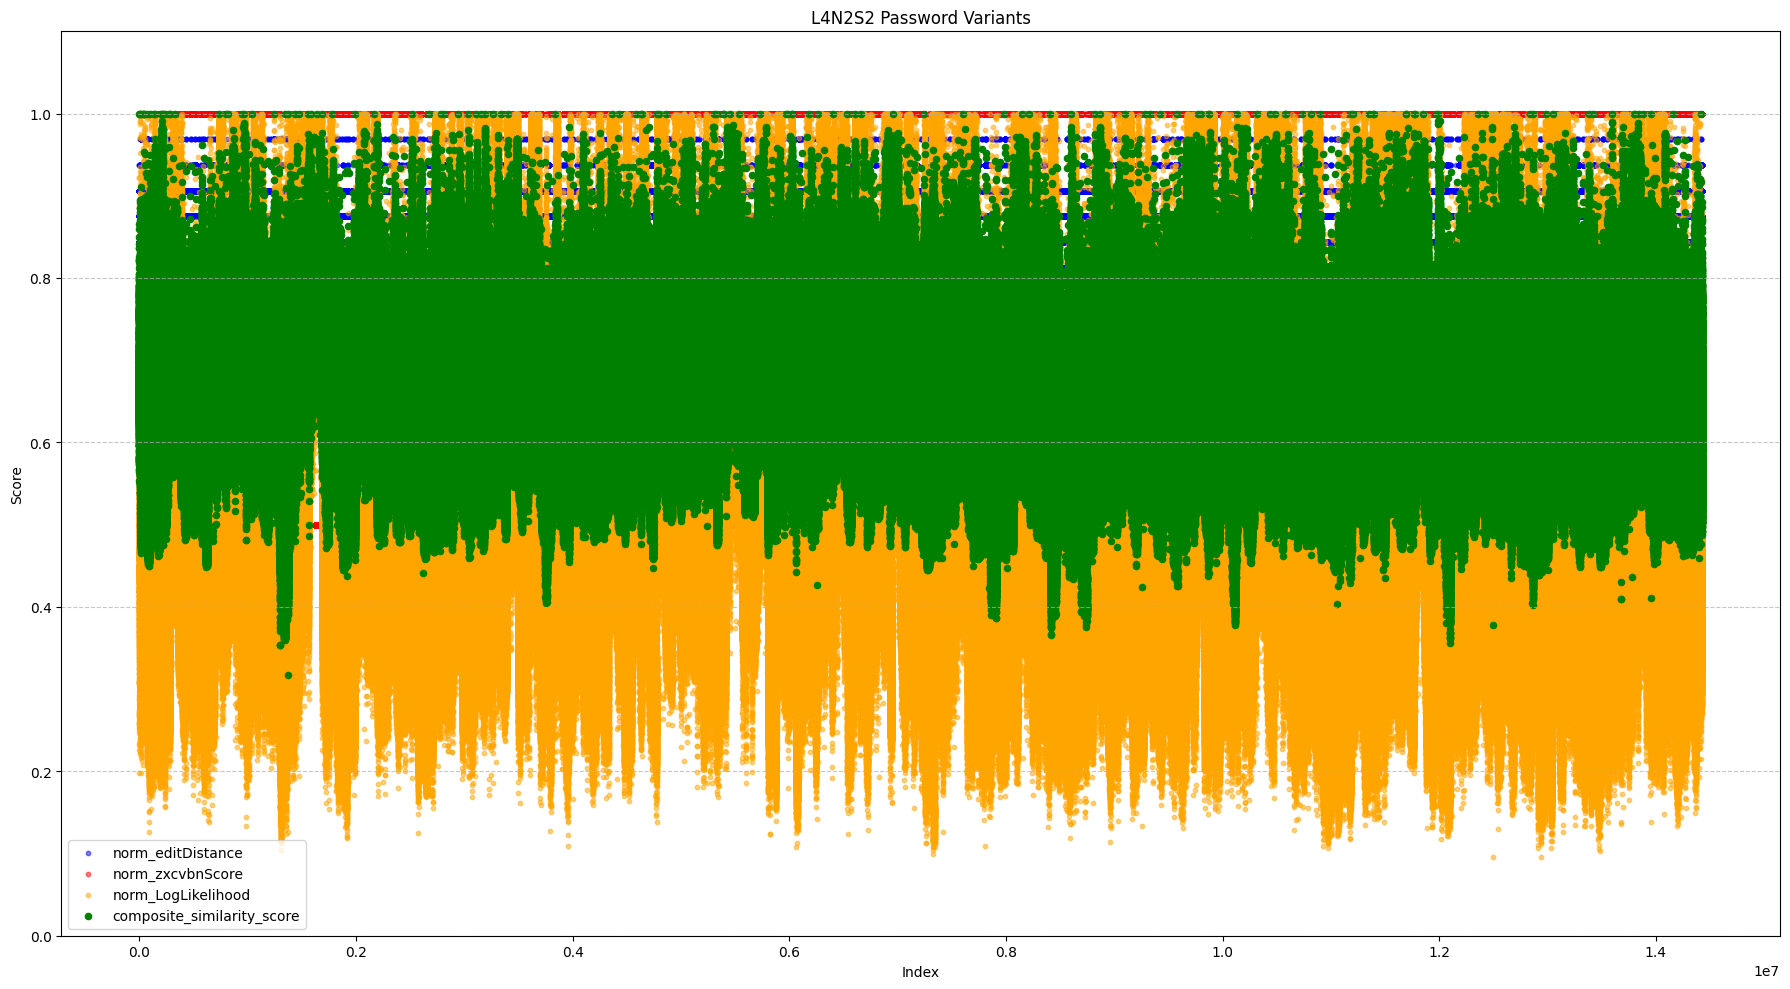

In [11]:
create_scatter_plot('L4N2S2 Password Variants')

## L4N3S1

In [ ]:
# Read the file
with open('test-L4N3S1.csv', 'r') as file:
    lines = file.readlines()
# Process the lines
data = []
for line in lines[1:]:  # Skip the header line
    parts = line.strip().split(' - ', 1)
    if len(parts) == 2:
        _, fields = parts
        data.append(fields.split('\t'))
print(f"Data: {len(data)}")
# Create DataFrame
columns = ['datetime','orig_pw', 'orig_pattern', 'orig_zxcvbn_score', 'orig_zxcvbn_guesses',
           'orig_log_likelihood', 'pw_variant', 'pattern', 'pw_zxcvbn_score',
           'pw_zxcvbn_guesses', 'pw_log_likelihood', 'edit_distance', 'similarity_ratio']
df = pd.DataFrame(data, columns=columns)

# Convert necessary columns to numeric
numeric_columns = ['orig_zxcvbn_score', 'orig_zxcvbn_guesses', 'orig_log_likelihood',
                   'pw_zxcvbn_score', 'pw_zxcvbn_guesses', 'pw_log_likelihood',
                   'edit_distance', 'similarity_ratio']
for col in numeric_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Filter rows where edit_distance
df_filtered = df.copy()

Data: 9676167


In [ ]:
compute()

Debugging Values:
Normalized Edit Distance: count    9.676167e+06
mean     8.442189e-01
std      3.644038e-02
min      6.250000e-01
25%      8.125000e-01
50%      8.437500e-01
75%      8.750000e-01
max      1.000000e+00
Name: normalized_editDistance, dtype: float64
Normalized zxcvbn Score: count    9.676167e+06
mean     6.659928e-01
std      1.406752e-01
min      2.500000e-01
25%      5.000000e-01
50%      7.500000e-01
75%      7.500000e-01
max      1.000000e+00
Name: normalized_zxcvbnScore, dtype: float64
Normalized Log Likelihood: count    9.676167e+06
mean     4.988699e-01
std      1.622170e-01
min      6.100623e-02
25%      3.801989e-01
50%      4.776547e-01
75%      5.975984e-01
max      1.000000e+00
Name: normalized_logLikelihood, dtype: float64
composite_similarity_score: count    9.676167e+06
mean     6.437002e-01
std      8.292089e-02
min      2.784578e-01
25%      5.896072e-01
50%      6.396169e-01
75%      6.954376e-01
max      1.000000e+00
Name: composite_similarity_score, 

<ipython-input-4-62e0debbb878>:18: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


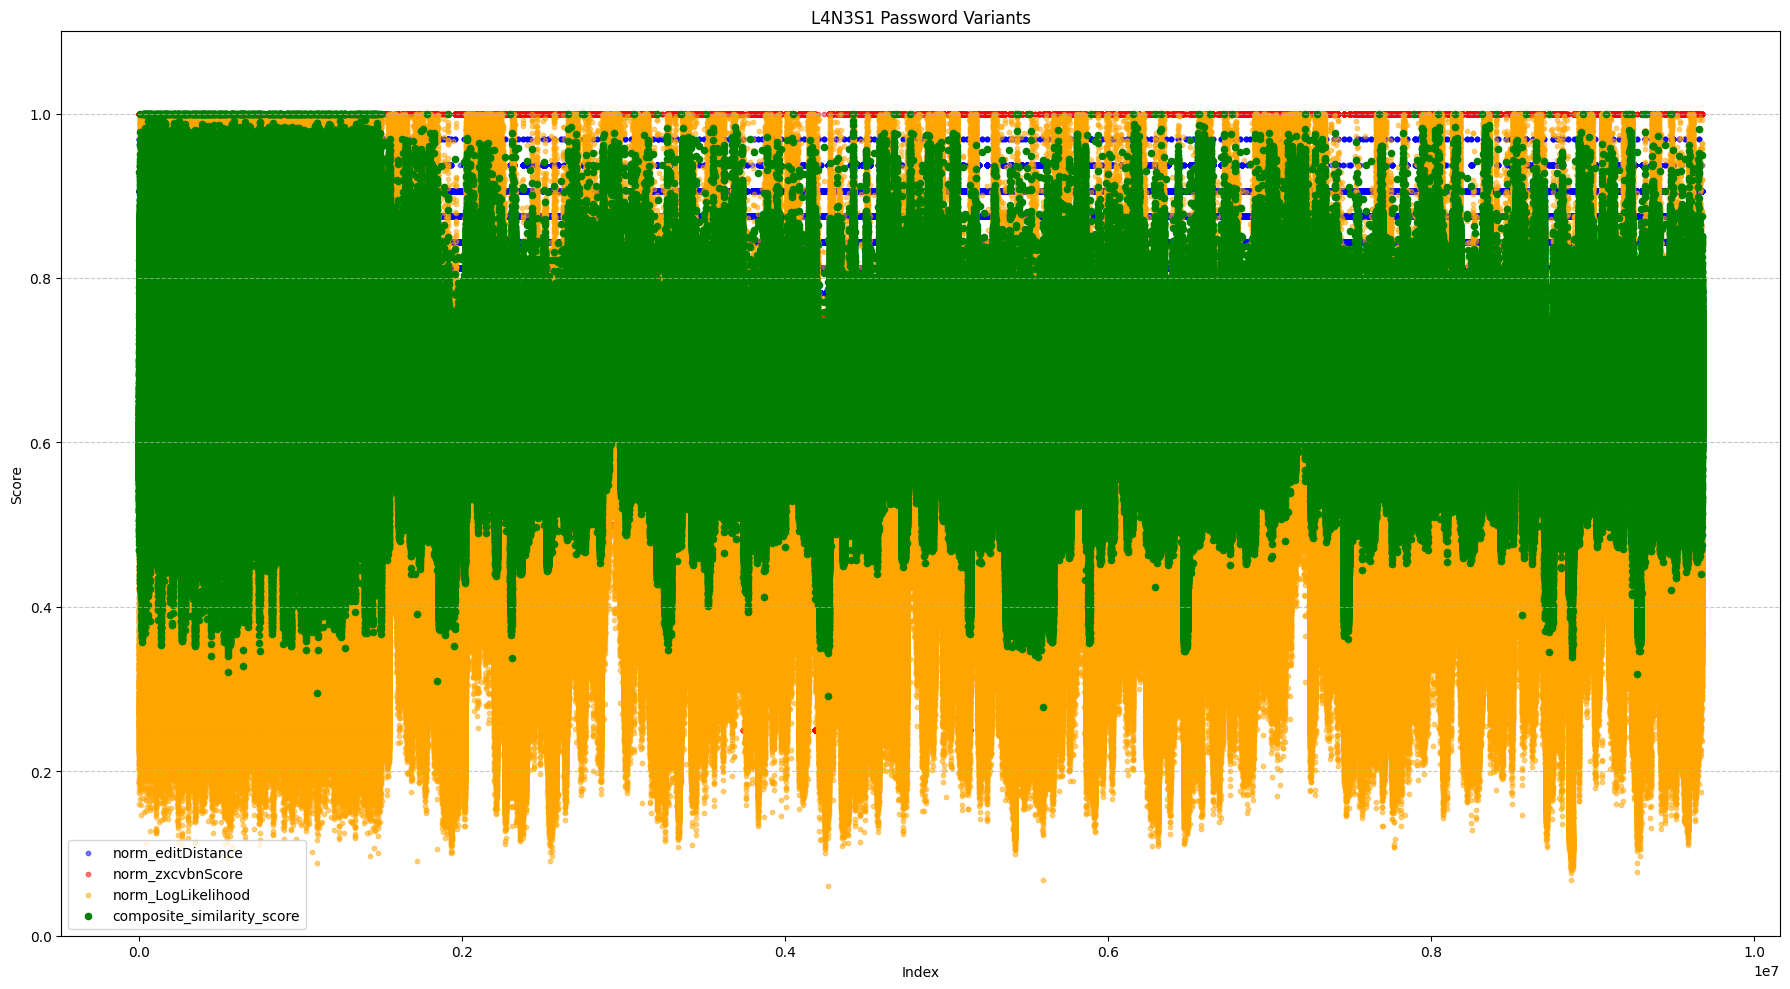

In [ ]:
create_scatter_plot('L4N3S1 Password Variants')

##N2L1N2L1N2 orig_pw: 16t09i88

In [ ]:
# Read the file
with open('test-16t09i88.csv', 'r') as file:
    lines = file.readlines()
# Process the lines
data = []
for line in lines[1:]:  # Skip the header line
    parts = line.strip().split(' - ', 1)
    if len(parts) == 2:
        _, fields = parts
        data.append(fields.split('\t'))
print(f"Data: {len(data)}")
# Create DataFrame
columns = ['datetime','orig_pw', 'orig_pattern', 'orig_zxcvbn_score', 'orig_zxcvbn_guesses',
           'orig_log_likelihood', 'pw_variant', 'pattern', 'pw_zxcvbn_score',
           'pw_zxcvbn_guesses', 'pw_log_likelihood', 'edit_distance', 'similarity_ratio']
df = pd.DataFrame(data, columns=columns)

# Convert necessary columns to numeric
numeric_columns = ['orig_zxcvbn_score', 'orig_zxcvbn_guesses', 'orig_log_likelihood',
                   'pw_zxcvbn_score', 'pw_zxcvbn_guesses', 'pw_log_likelihood',
                   'edit_distance', 'similarity_ratio']
for col in numeric_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Filter rows where edit_distance
df_filtered = df.copy()

Data: 2335


In [ ]:
compute()

Debugging Values:
Normalized Edit Distance: count    2334.000000
mean        0.863285
std         0.036294
min         0.750000
25%         0.843750
50%         0.843750
75%         0.906250
max         0.968750
Name: normalized_editDistance, dtype: float64
Normalized zxcvbn Score: count    2334.000000
mean        0.787489
std         0.095651
min         0.500000
25%         0.750000
50%         0.750000
75%         0.750000
max         1.000000
Name: normalized_zxcvbnScore, dtype: float64
Normalized Log Likelihood: count    2334.000000
mean        0.377430
std         0.105556
min         0.165333
25%         0.295513
50%         0.361610
75%         0.441761
max         0.993070
Name: normalized_logLikelihood, dtype: float64
composite_similarity_score: count    2334.000000
mean        0.642414
std         0.046066
min         0.482516
25%         0.605765
50%         0.642082
75%         0.672814
max         0.981603
Name: composite_similarity_score, dtype: float64
Number of unique 

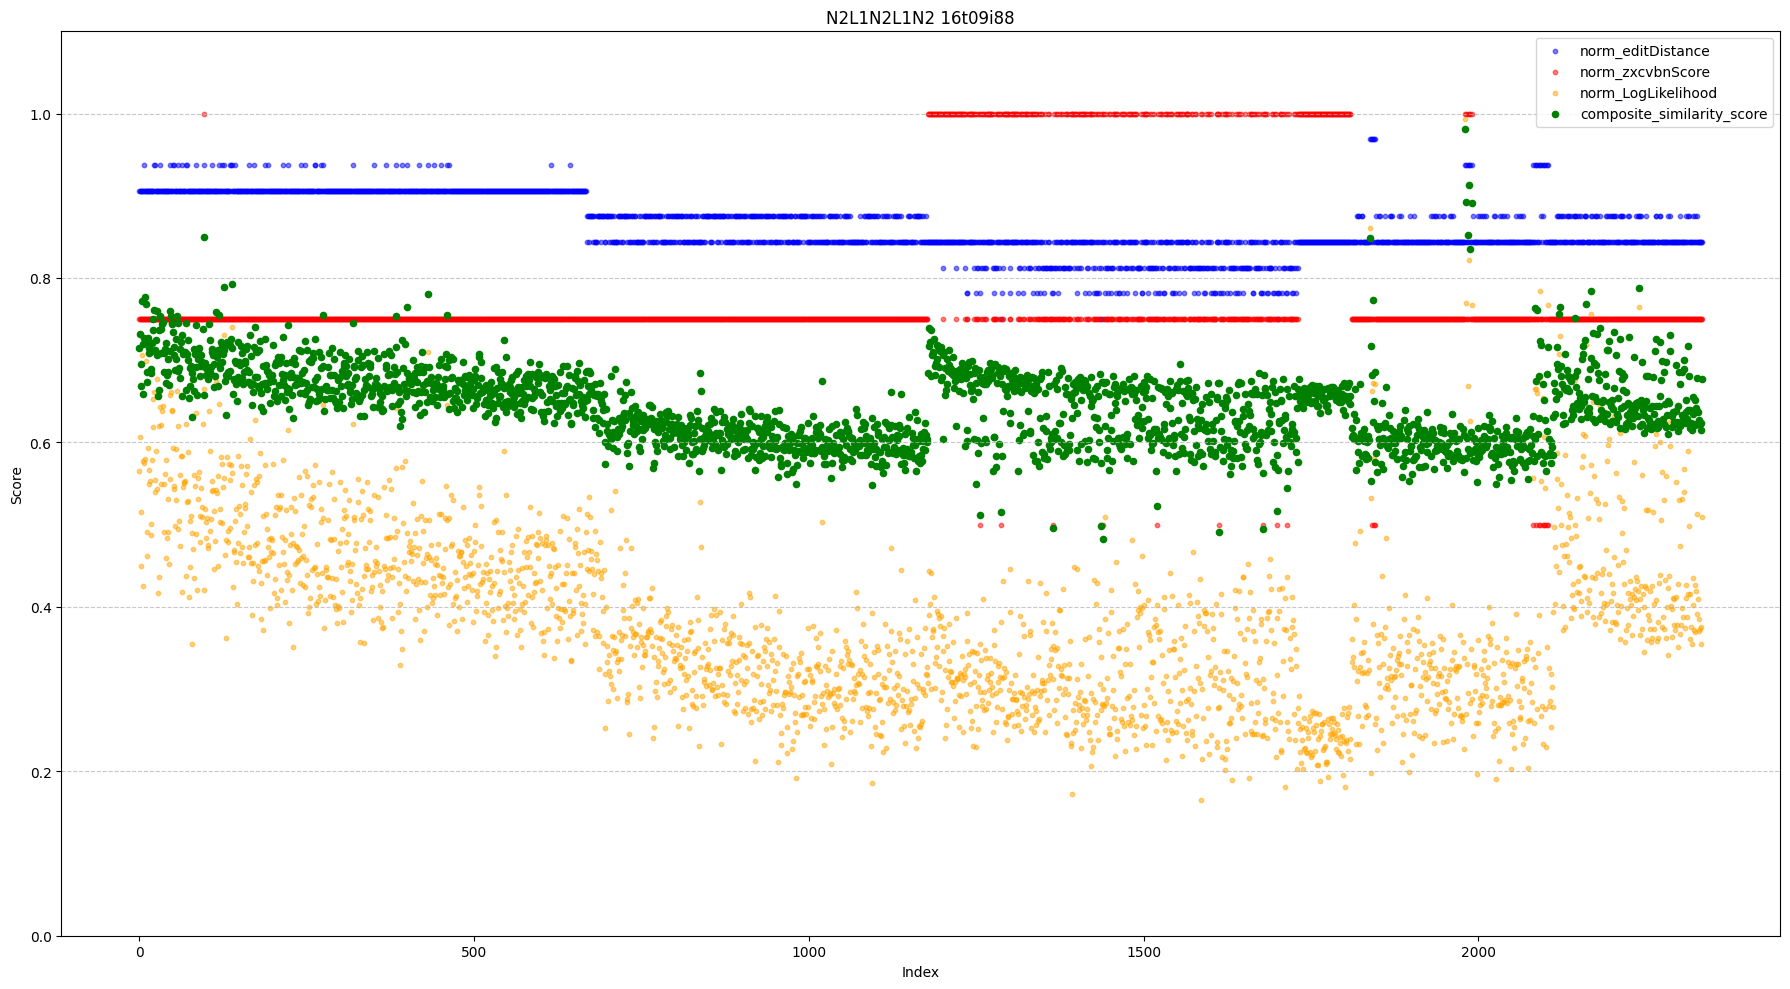

In [ ]:
create_scatter_plot('N2L1N2L1N2 16t09i88')

## L4 orig_pw: pass

In [ ]:
# Read the file
with open('test-pass.csv', 'r') as file:
    lines = file.readlines()
# Process the lines
data = []
for line in lines[1:]:  # Skip the header line
    parts = line.strip().split(' - ', 1)
    if len(parts) == 2:
        _, fields = parts
        data.append(fields.split('\t'))
print(f"Data: {len(data)}")
# Create DataFrame
columns = ['datetime','orig_pw', 'orig_pattern', 'orig_zxcvbn_score', 'orig_zxcvbn_guesses',
           'orig_log_likelihood', 'pw_variant', 'pattern', 'pw_zxcvbn_score',
           'pw_zxcvbn_guesses', 'pw_log_likelihood', 'edit_distance', 'similarity_ratio']
df = pd.DataFrame(data, columns=columns)

# Convert necessary columns to numeric
numeric_columns = ['orig_zxcvbn_score', 'orig_zxcvbn_guesses', 'orig_log_likelihood',
                   'pw_zxcvbn_score', 'pw_zxcvbn_guesses', 'pw_log_likelihood',
                   'edit_distance', 'similarity_ratio']
for col in numeric_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Filter rows where edit_distance
df_filtered = df.copy()

Data: 55643


In [ ]:
compute()

Debugging Values:
Normalized Edit Distance: count    55643.000000
mean         0.782169
std          0.039650
min          0.593750
25%          0.750000
50%          0.781250
75%          0.812500
max          0.875000
Name: normalized_editDistance, dtype: float64
Normalized zxcvbn Score: count    55643.000000
mean         0.405118
std          0.122672
min          0.000000
25%          0.250000
50%          0.500000
75%          0.500000
max          0.750000
Name: normalized_zxcvbnScore, dtype: float64
Normalized Log Likelihood: count    55643.000000
mean         0.789180
std          0.143229
min          0.251825
25%          0.692735
50%          0.808816
75%          0.907578
max          0.999982
Name: normalized_logLikelihood, dtype: float64
composite_similarity_score: count    55643.000000
mean         0.653006
std          0.076529
min          0.328200
25%          0.599459
50%          0.655878
75%          0.717980
max          0.812232
Name: composite_similarity_score, 

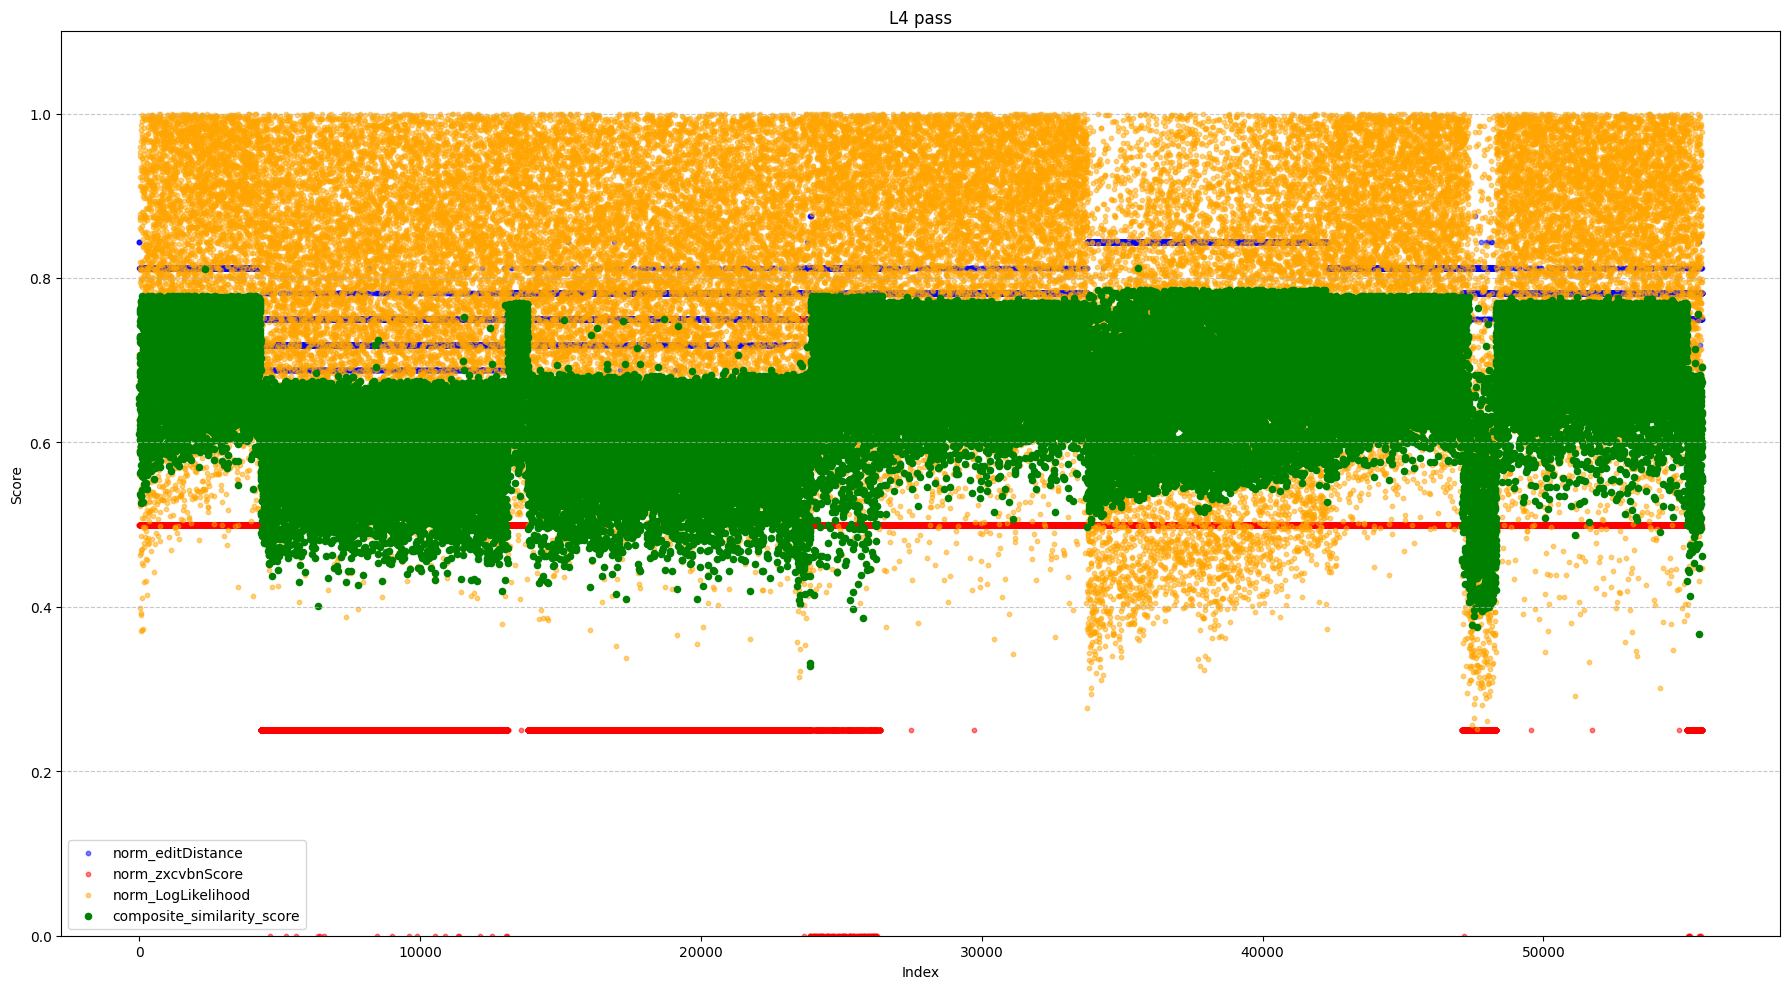

In [ ]:
create_scatter_plot('L4 pass')

## S1L3S1N1*

In [6]:
# Read the file
with open('test-S1L3S1N1*.csv', 'r') as file:
    lines = file.readlines()
# Process the lines
data = []
for line in lines[1:]:  # Skip the header line
    parts = line.strip().split(' - ', 1)
    if len(parts) == 2:
        _, fields = parts
        data.append(fields.split('\t'))
print(f"Data: {len(data)}")
# Create DataFrame
columns = ['datetime','orig_pw', 'orig_pattern', 'orig_zxcvbn_score', 'orig_zxcvbn_guesses',
           'orig_log_likelihood', 'pw_variant', 'pattern', 'pw_zxcvbn_score',
           'pw_zxcvbn_guesses', 'pw_log_likelihood', 'edit_distance', 'similarity_ratio']
df = pd.DataFrame(data, columns=columns)

# Convert necessary columns to numeric
numeric_columns = ['orig_zxcvbn_score', 'orig_zxcvbn_guesses', 'orig_log_likelihood',
                   'pw_zxcvbn_score', 'pw_zxcvbn_guesses', 'pw_log_likelihood',
                   'edit_distance', 'similarity_ratio']
for col in numeric_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Filter rows where edit_distance
df_filtered = df.copy()

Data: 359659


In [7]:
compute()

Debugging Values:
Normalized Edit Distance: count    359659.000000
mean          0.834165
std           0.045229
min           0.687500
25%           0.812500
50%           0.843750
75%           0.875000
max           1.000000
Name: normalized_editDistance, dtype: float64
Normalized zxcvbn Score: count    359659.000000
mean          0.649856
std           0.196538
min           0.250000
25%           0.500000
50%           0.750000
75%           0.750000
max           1.000000
Name: normalized_zxcvbnScore, dtype: float64
Normalized Log Likelihood: count    359659.000000
mean          0.646670
std           0.209104
min           0.065991
25%           0.516801
50%           0.662836
75%           0.806826
max           1.000000
Name: normalized_logLikelihood, dtype: float64
composite_similarity_score: count    359659.000000
mean          0.694659
std           0.090561
min           0.394641
25%           0.629318
50%           0.690454
75%           0.756648
max           1.000000
Na

<ipython-input-4-62e0debbb878>:18: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


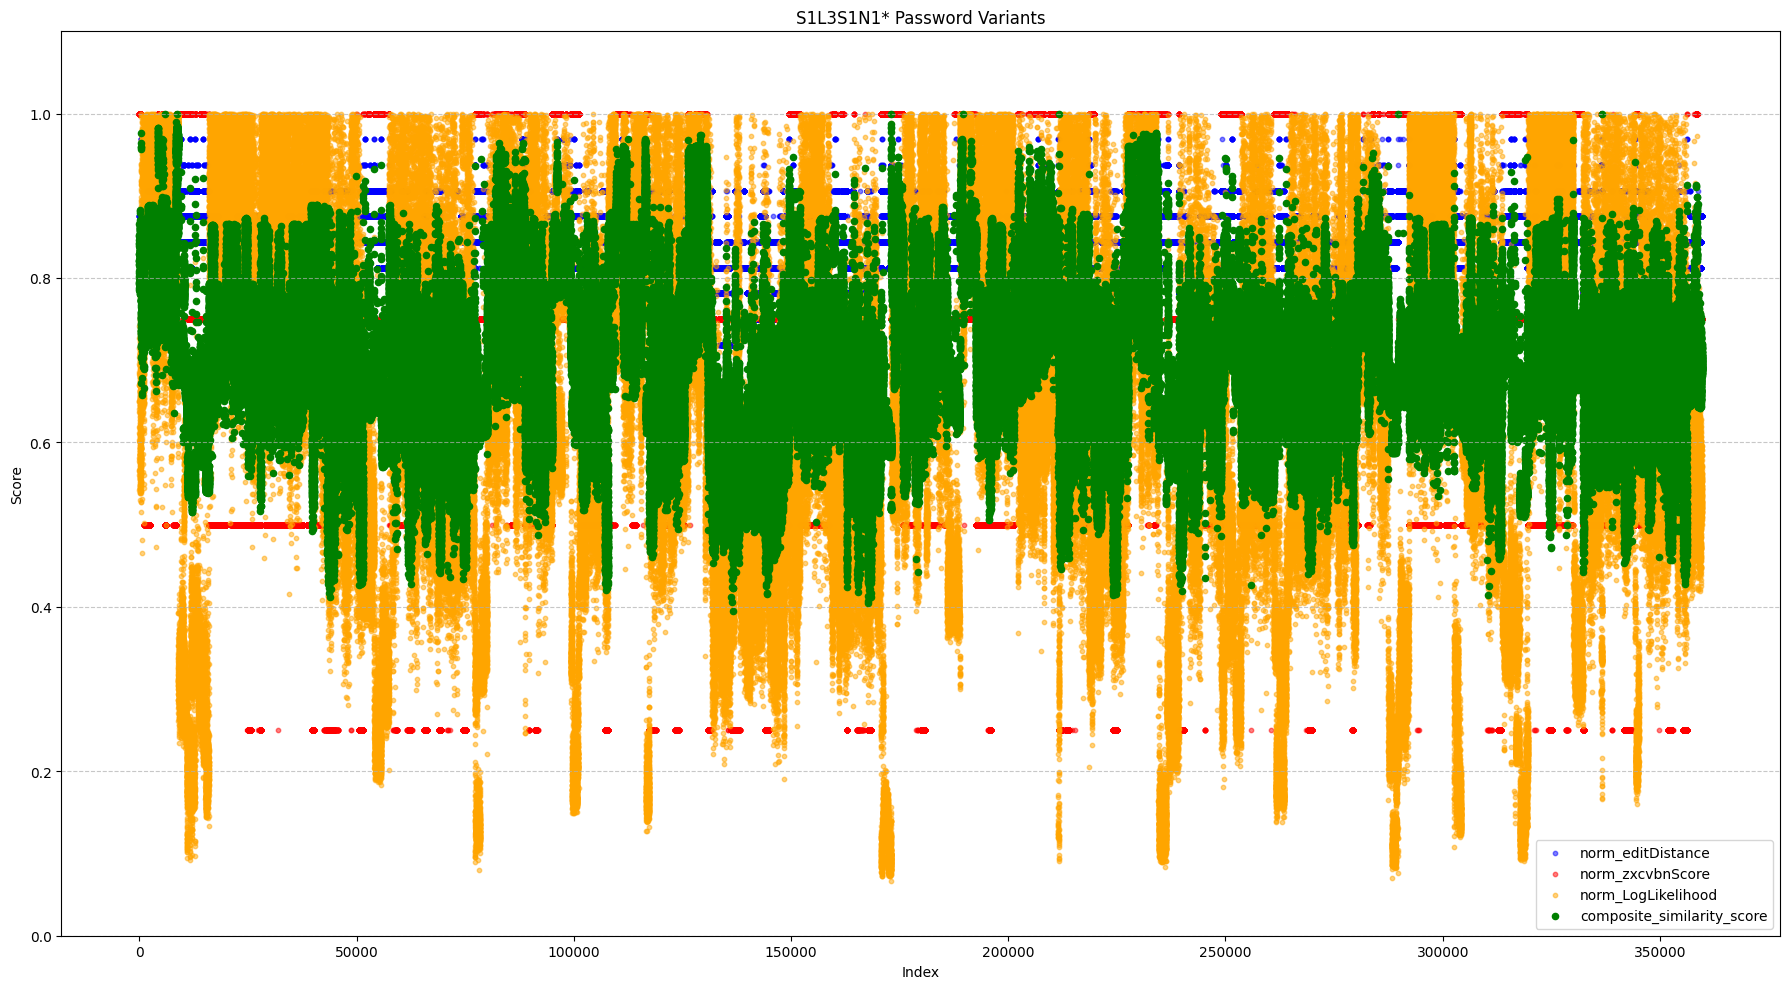

In [8]:
create_scatter_plot('S1L3S1N1* Password Variants')

## L6 N2*

In [ ]:
# Read the file
with open('test-L6N2*.csv', 'r') as file:
    lines = file.readlines()
# Process the lines
data = []
for line in lines[1:]:  # Skip the header line
    parts = line.strip().split(' - ', 1)
    if len(parts) == 2:
        _, fields = parts
        data.append(fields.split('\t'))
print(f"Data: {len(data)}")
# Create DataFrame
columns = ['datetime','orig_pw', 'orig_pattern', 'orig_zxcvbn_score', 'orig_zxcvbn_guesses',
           'orig_log_likelihood', 'pw_variant', 'pattern', 'pw_zxcvbn_score',
           'pw_zxcvbn_guesses', 'pw_log_likelihood', 'edit_distance', 'similarity_ratio']
df = pd.DataFrame(data, columns=columns)

# Convert necessary columns to numeric
numeric_columns = ['orig_zxcvbn_score', 'orig_zxcvbn_guesses', 'orig_log_likelihood',
                   'pw_zxcvbn_score', 'pw_zxcvbn_guesses', 'pw_log_likelihood',
                   'edit_distance', 'similarity_ratio']
for col in numeric_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Filter rows where edit_distance
df_filtered = df.copy()

In [ ]:
compute()

In [ ]:
create_scatter_plot('L6 N2* Password Variants')

## N1L1N2*

In [ ]:
# Read the file
with open('test-N1L1N2*.csv', 'r') as file:
    lines = file.readlines()
# Process the lines
data = []
for line in lines[1:]:  # Skip the header line
    parts = line.strip().split(' - ', 1)
    if len(parts) == 2:
        _, fields = parts
        data.append(fields.split('\t'))
print(f"Data: {len(data)}")
# Create DataFrame
columns = ['datetime','orig_pw', 'orig_pattern', 'orig_zxcvbn_score', 'orig_zxcvbn_guesses',
           'orig_log_likelihood', 'pw_variant', 'pattern', 'pw_zxcvbn_score',
           'pw_zxcvbn_guesses', 'pw_log_likelihood', 'edit_distance', 'similarity_ratio']
df = pd.DataFrame(data, columns=columns)

# Convert necessary columns to numeric
numeric_columns = ['orig_zxcvbn_score', 'orig_zxcvbn_guesses', 'orig_log_likelihood',
                   'pw_zxcvbn_score', 'pw_zxcvbn_guesses', 'pw_log_likelihood',
                   'edit_distance', 'similarity_ratio']
for col in numeric_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Filter rows where edit_distance
df_filtered = df.copy()

In [ ]:
compute()

In [ ]:
create_scatter_plot('N1L1N2* Password Variants')